<a href="https://colab.research.google.com/github/praneethk002/MIProj/blob/main/ventilator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [4]:
df_train = pd.read_csv('train1.csv')
df_train = df_train.drop('id', axis=1)

In [1]:
def plot_create(x, y):
    plt.plot(x, y, '-', label=y.name)

def process_visualisation_with_preds(df, df_preds, breath_id):
    plt.figure(figsize=(14, 6))
    plt.title('Breath Id - {}'.format(breath_id))
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df[df['breath_id'] == breath_id]['pressure'])
    plot_create(df[df['breath_id'] == breath_id]['time_step'],
                df_preds)
    plt.grid()
    plt.legend()
    plt.ylabel('Value')
    plt.show()

def add_features(df):
    df['u_in_cumsum'] = df['u_in'].groupby(df['breath_id']).cumsum()
    df['u_in_lag_1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_in_lag_2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_in_lag_3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_in_rolling_mean_3'] = df.groupby('breath_id')['u_in'].shift().rolling(3).mean()
    df['u_in_rolling_mean_5'] = df.groupby('breath_id')['u_in'].shift().rolling(5).mean()
    df['u_in_begin'] = df.groupby('breath_id')['u_in'].transform('first')
    df['u_in_end'] = df.groupby('breath_id')['u_in'].transform('last')
    df['u_in_min'] = df.groupby('breath_id')['u_in'].transform('min')
    df['u_in_max'] = df.groupby('breath_id')['u_in'].transform('max')
    df['u_in_median'] = df.groupby('breath_id')['u_in'].transform('median')
    df = df.fillna(0)
    df = df.drop(['breath_id', 'u_in', 'u_out'], axis=1)
    return df

def train_and_score(model, X_train, X_valid, y_train, y_valid):
    model.fit(X_train, y_train)
    return mean_absolute_error(y_valid, model.predict(X_valid))

In [5]:
N = 150000

X = df_train[:N].copy()
X = X.drop('pressure', axis=1)
X = add_features(X)
y = df_train[:N]['pressure']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=555)

In [9]:
from sklearn.preprocessing import StandardScaler
sc =  StandardScaler()

sc.fit(X_train)

X_train = sc.transform(X_train)
X_valid = sc.transform(X_valid)

In [10]:
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor()
rf_model = RandomForestRegressor()
et_model = ExtraTreesRegressor()

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [15]:
model = Sequential()
model.add(Dense(units=1024, kernel_initializer='normal', activation='relu', input_shape=[X_train.shape[1]]))
model.add(Dense(units=1024, kernel_initializer='normal', activation='relu', ))
model.add(layers.Dropout(.2))
model.add(Dense(units=2024, kernel_initializer='normal', activation='relu', ))
model.add(Dense(units=2024, kernel_initializer='normal', activation='relu', ))
model.add(layers.Dropout(.2))
model.add(Dense(units=2024, kernel_initializer='normal', activation='relu', ))
model.add(Dense(units=2024, kernel_initializer='normal', activation='relu', ))
model.add(layers.Dropout(.1))
model.add(Dense(units=700, kernel_initializer='normal', activation='relu', ))
model.add(layers.Dropout(.1))
model.add(Dense(units=512, kernel_initializer='normal', activation='relu', ))
model.add(Dense(units=64, kernel_initializer='normal', activation='relu', ))
model.add(Dense(units=32, kernel_initializer='normal', activation='relu', ))
model.add(Dense(units=1, kernel_initializer='normal'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              15360     
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 2024)              2074600   
                                                                 
 dense_3 (Dense)             (None, 2024)              4098600   
                                                                 
 dropout_1 (Dropout)         (None, 2024)              0         
                                                                 
 dense_4 (Dense)             (None, 2024)             

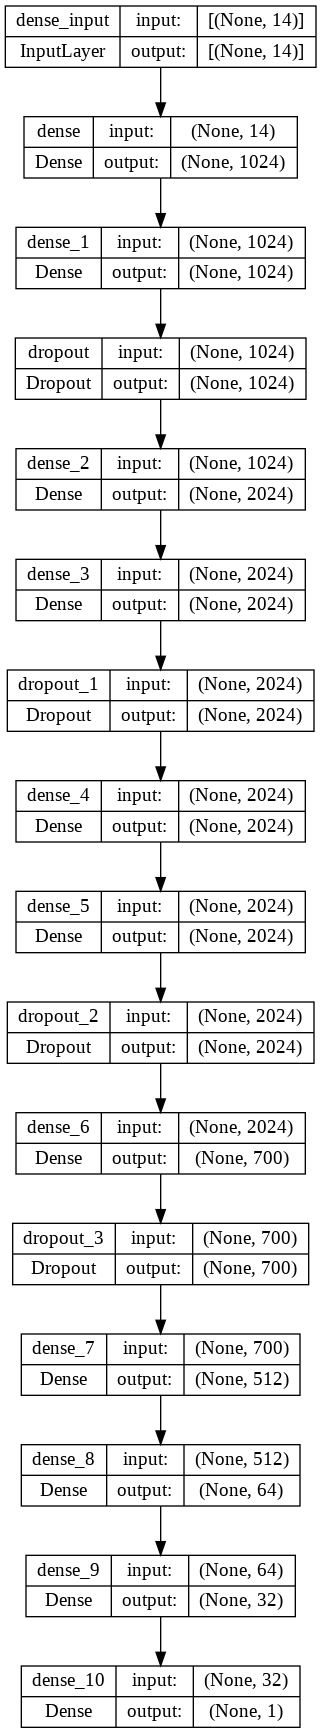

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'model.png', show_shapes=True)

In [23]:
model.compile(loss='mean_squared_error', optimizer=Adam())

In [18]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                         patience = 10,
                         verbose = 1,
                         factor = 0.70,
                         min_lr = 1e-2)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=10)

In [24]:
%time
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=128, epochs=200, callbacks=[lrd, mcp, es])

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs
Epoch 1/200
25/25 [==============================] - 13s 452ms/step - loss: 124.9414 - val_loss: 53.5162 - lr: 0.0010
Epoch 2/200
25/25 [==============================] - 12s 471ms/step - loss: 30.0936 - val_loss: 22.0828 - lr: 0.0010
Epoch 3/200
25/25 [==============================] - 13s 503ms/step - loss: 13.7845 - val_loss: 10.8975 - lr: 0.0010
Epoch 4/200
25/25 [==============================] - 12s 471ms/step - loss: 9.0655 - val_loss: 10.1310 - lr: 0.0010
Epoch 5/200
25/25 [==============================] - 11s 438ms/step - loss: 9.1854 - val_loss: 16.0326 - lr: 0.0010
Epoch 6/200
25/25 [==============================] - 11s 447ms/step - loss: 6.7298 - val_loss: 3.9412 - lr: 0.0010
Epoch 7/200
25/25 [==============================] - 11s 427ms/step - loss: 4.8316 - val_loss: 5.0901 - lr: 0.0010
Epoch 8/200
25/25 [==============================] - 14s 556ms/step - loss: 3.9503 - val_loss: 6.4022 - lr: 0.0010
Epoch 9

In [26]:
model.evaluate(X_valid, y_valid)

32/32 [==============================] - 1s 38ms/step - loss: 3.0767


3.0766541957855225

In [28]:
y_pred = model.predict(X_valid)
y_pred

32/32 [==============================] - 1s 34ms/step


array([[13.696915 ],
       [ 6.7304063],
       [ 8.527044 ],
       [ 4.992665 ],
       [ 5.8963585],
       [ 8.68901  ],
       [ 6.313931 ],
       [ 6.073165 ],
       [ 9.4054365],
       [ 5.704502 ],
       [ 6.3743963],
       [ 6.139126 ],
       [ 5.446826 ],
       [ 5.447633 ],
       [ 6.5960884],
       [13.422579 ],
       [ 5.7552223],
       [ 5.5738297],
       [16.705717 ],
       [ 6.7229743],
       [11.485392 ],
       [ 5.4043403],
       [ 6.6256585],
       [ 6.3343706],
       [ 7.2159805],
       [ 5.386773 ],
       [ 2.6500435],
       [10.801992 ],
       [10.017196 ],
       [10.242874 ],
       [ 6.892024 ],
       [ 5.8113747],
       [34.43418  ],
       [ 5.562934 ],
       [ 5.4343076],
       [ 6.0972414],
       [13.893864 ],
       [ 6.2899923],
       [ 5.759446 ],
       [ 8.619107 ],
       [ 4.9747915],
       [ 6.130125 ],
       [24.498175 ],
       [ 9.744594 ],
       [13.175272 ],
       [ 4.735562 ],
       [11.201495 ],
       [ 6.30

In [29]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [30]:
mean_absolute_error(y_valid,y_pred)

1.1166269893460734

In [11]:
display(
    pd.DataFrame(data=([train_and_score(linear_model, X_train, X_valid, y_train, y_valid)],
                       [train_and_score(tree_model, X_train, X_valid, y_train, y_valid)],
                       [train_and_score(rf_model, X_train, X_valid, y_train, y_valid)],
                       [train_and_score(et_model, X_train, X_valid, y_train, y_valid)]
                      ),
                 columns=['Result MAE'],
                 index=['Linear', 'Decision Tree', 'Random Forest', 'Extra Trees'])
)

,Result MAE
Linear,3.958312
Decision Tree,0.818879
Random Forest,0.627534
Extra Trees,0.542745


In [12]:
bid = 16600

X_df_vis = df_train[df_train['breath_id'] == bid].reset_index()
X_df_vis = add_features(X_df_vis)
X_df_vis = X_df_vis.drop(['index', 'pressure'], axis=1)

print('Pressure predictions by Linear Model:')
# process_visualisation_with_preds(df_train, pd.Series(linear_model.predict(X_df_vis), name='predictions'), bid)
print('Pressure predictions by Tree Model:')
process_visualisation_with_preds(df_train, pd.Series(tree_model.predict(X_df_vis), name='predictions'), bid)
print('Pressure predictions by Random Forest Model:')
process_visualisation_with_preds(df_train, pd.Series(rf_model.predict(X_df_vis), name='predictions'), bid)
print('Pressure predictions by Extra Trees Model:')
process_visualisation_with_preds(df_train, pd.Series(et_model.predict(X_df_vis), name='predictions'), bid)

Pressure predictions by Linear Model:


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


ValueError: ignored